In [1]:
from optimizers.simulations._order import simulate_from_order_func
from sklearn.model_selection import train_test_split
from optimizers.utils._utils import get_csv_data
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
opens = get_csv_data("data/hourly_open_data.csv")
closes = get_csv_data("data/hourly_close_data.csv")

train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)

In [3]:
# Constants
# 90 3.5 -3.8 1.5 1.000000e-07 0.3

PERIOD = 90
UPPER = 3.5
LOWER = -2.0
EXIT = 1.5
DELTA = 1e-7
VT = 0.4
BURNIN = 2000

In [4]:
closes = closes[["XRP-USDT", "VET-USDT"]]
opens = opens[["XRP-USDT", "VET-USDT"]]

In [5]:
pf = simulate_from_order_func(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq="h",
    hedge="beta",
    mode="cummlog",
    slippage=0.0005,
    commission=0.0008,
)

-0.023674158585916795


<AxesSubplot:xlabel='time'>

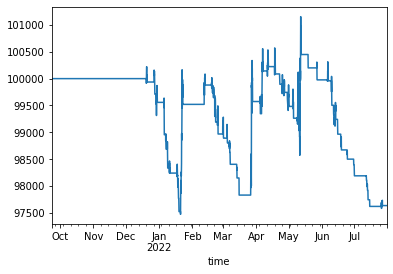

In [6]:
print(pf.total_return())

pf.value().plot()

In [7]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()
res.PnL[res.PnL > 0].shape[0] / res.shape[0]

0.1694915254237288

-40.1256925185029


<AxesSubplot:xlabel='Entry Timestamp'>

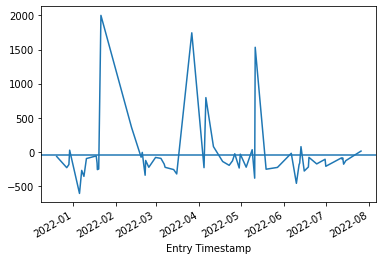

In [8]:
plt.axhline(res.PnL.mean())

print(res.PnL.mean())

res.PnL.plot()

In [9]:
res = pd.read_csv("results.csv", index_col=[0,1,2,3,4,5])

In [10]:
res[res["trade_count"] > 15]

Duration  Win Rate  profit_ratio  \
90 3.5 -2.1 1.5 1.000000e-07 0.4     770.0  0.326087      1.446155   
                             0.3     750.0  0.310905      1.597152   
       -2.4 1.5 1.000000e-01 0.3      60.0  0.179562      0.563197   

                                  total_return  trade_count  Weighted Average  \
90 3.5 -2.1 1.5 1.000000e-07 0.4      0.003505    16.500000          0.303030   
                             0.3      0.001591    16.333333          0.285714   
       -2.4 1.5 1.000000e-01 0.3     -0.053334    29.000000          0.178161   

                                   fitness      p  
90 3.5 -2.1 1.5 1.000000e-07 0.4  0.195805  0.667  
                             0.3  0.211431  0.667  
       -2.4 1.5 1.000000e-01 0.3  0.000000  0.667